In [1]:
import numpy as np
from numpy.core.fromnumeric import shape
import pandas as pd
import datetime as dt
import glob
import pickle
import global_variables as gv
import functions as f
import random
import matplotlib.pyplot as plt

In [2]:
# Import journey and price data

journeys_range = pickle.load(open('Outputs/journeys_range','rb'))
price_data = pickle.load(open('Outputs/price_data','rb'))


In [3]:
journeys_range

Branch_ID Start_Time_of_Route   End_Time_of_Route  \
date       Route_ID                                                      
2019-02-10 2104108         513 2019-02-10 05:27:00 2019-02-10 12:35:00   
           2104123         513 2019-02-10 13:15:00 2019-02-10 21:24:59   
2019-02-11 2106400         513 2019-02-11 05:15:00 2019-02-11 13:49:00   
2019-02-12 2107385         513 2019-02-12 05:15:00 2019-02-12 13:16:00   
           2107404         513 2019-02-12 13:54:59 2019-02-12 21:17:00   
2019-02-13 2108366         513 2019-02-13 05:16:59 2019-02-13 12:53:00   
           2108381         513 2019-02-13 13:15:00 2019-02-13 20:57:00   
2019-02-14 2109407         513 2019-02-14 05:15:00 2019-02-14 13:41:00   
           2109428         513 2019-02-14 13:46:00 2019-02-14 22:03:00   
2019-02-15 2110622         513 2019-02-15 05:15:00 2019-02-15 13:37:00   
2019-02-16 2111859         513 2019-02-16 05:29:59 2019-02-16 13:04:00   
           2111860         513 2019-02-16 13:15:00 2019-02-16 20:43:00   
2019-02-17 2112861         513 2019-02-17 05:29:59 2019-02-17 13:03:00   
           2112873         513 2019-02-17 13:17:00 2019-02-17 20:33:00   

                     Energy_Required  Vehicle_ID      Next_Departure  \
date       Route_ID                                                    
2019-02-10 2104108         26.571267           3 2019-02-10 13:15:00   
           2104123         27.635793           3 2019-02-11 05:15:00   
2019-02-11 2106400         24.289653           3 2019-02-12 05:15:00   
2019-02-12 2107385         27.290313           3 2019-02-12 13:54:59   
           2107404         23.318893           3 2019-02-13 05:16:59   
2019-02-13 2108366         26.008340           3 2019-02-13 13:15:00   
           2108381         25.367420           3 2019-02-14 05:15:00   
2019-02-14 2109407         26.701467           3 2019-02-14 13:46:00   
           2109428         26.019727           3 2019-02-15 05:15:00   
2019-02-15 2110622         28.333793           3 2019-02-16 05:29:59   
2019-02-16 2111859         24.892733           3 2019-02-16 13:15:00   
           2111860         22.695913           3 2019-02-17 05:29:59   
2019-02-17 2112861         26.496700           3 2019-02-17 13:17:00   
           2112873         26.706473           3 2019-02-18 05:16:59   

                       Previous_Arrival  
date       Route_ID                      
2019-02-10 2104108  2019-02-09 21:51:00  
           2104123  2019-02-10 12:35:00  
2019-02-11 2106400  2019-02-10 21:24:59  
2019-02-12 2107385  2019-02-11 13:49:00  
           2107404  2019-02-12 13:16:00  
2019-02-13 2108366  2019-02-12 21:17:00  
           2108381  2019-02-13 12:53:00  
2019-02-14 2109407  2019-02-13 20:57:00  
           2109428  2019-02-14 13:41:00  
2019-02-15 2110622  2019-02-14 22:03:00  
2019-02-16 2111859  2019-02-15 13:37:00  
           2111860  2019-02-16 13:04:00  
2019-02-17 2112861  2019-02-16 20:43:00  
           2112873  2019-02-17 13:03:00

In [71]:
# Create function for one route, in one day
def singleroute_BAU_schedule(journeys, day, route, eprice, SoC, vehicle):
    return_datetime = journeys.loc[(day, route),'End_Time_of_Route']
    departure_dt = journeys.loc[(day, route), 'Next_Departure']
    required_charge = gv.BATTERY_CAPACITY - SoC
    mask = ( (eprice['from'] >= dt.datetime.combine(day, gv.CHAR_ST)) 
    & (eprice['from'] < dt.datetime.combine(day + dt.timedelta(days=1), gv.CHAR_ST)))
    single_profile = eprice[mask][['from','unit_rate_excl_vat']].copy()
    timesidx = single_profile.index
    single_profile['Output_BAU'] = 0
    single_profile['Vehicle_ID'] = vehicle
    single_profile['SOC_BAU'] = SoC
    prev_idx = timesidx[0]
    for idx in timesidx:
        if single_profile.loc[idx,'from']  <= return_datetime:
            single_profile.loc[idx,'Output_BAU'] = 0
        elif single_profile.loc[idx,'from'] + dt.timedelta(minutes=30)> departure_dt:
            single_profile.loc[idx,'Output_BAU'] = 0
        elif gv.BATTERY_CAPACITY - SoC > gv.POWER_INT:
            single_profile.loc[idx,'Output_BAU'] = (gv.POWER_INT)
        elif gv.BATTERY_CAPACITY - SoC > 0:
            single_profile.loc[idx,'Output_BAU'] = gv.BATTERY_CAPACITY - SoC
        single_profile.loc[idx,'SOC_BAU'] = SoC + single_profile.loc[idx,'Output_BAU'] * gv.CHARGER_EFF
        SoC =  single_profile.loc[idx,'SOC_BAU']
    single_profile['Route_ID'] = route   
    single_profile['date'] = day
    # SoC at the end of the route will be initial SoC
    # + recharged in the timesidx loop
    # - consumed during the route itself
    SoC = SoC -  journeys.loc[(day, route),'Energy_Required'] 
    return single_profile, SoC

def BAU_charging(journeys, eprice):
    # Create df for charge profile, with time slots in that time range. 
    _, time_range = f.create_empty_schedule(journeys, eprice)
    #time_range = [dt.datetime(2019,2,10,11,0),dt.datetime(2019,2,12,11,0)]
    #print(time_range)
    # Iterate over each day
    dates = journeys.index.unique(level='date')
    # print(dates)
    day_profile = {}
    vehicles = journeys['Vehicle_ID'].unique()
    SOC_veh = dict.fromkeys(vehicles, gv.BATTERY_CAPACITY) #Full battery
    SOC_2 = []
    for date in dates:
        day = date.to_pydatetime()
        if day.date() == time_range[1].date():
            break
        # Iterate over routes, copy to correct column
        route_profiles = {}
        for route in journeys.loc[day].index:
            vehicle = journeys.at[(day,route),'Vehicle_ID']
            SoC = SOC_veh[vehicle] # last SoC of that vehicle
            route_profiles[route], SoC = singleroute_BAU_schedule(
                journeys, 
                day, 
                route, 
                eprice, 
                SoC,
                vehicle)
            SOC_veh[vehicle] = SoC
        day_profile[day] = pd.concat(list(route_profiles.values()))
    profiles = pd.concat(list(day_profile.values()))
    profiles.sort_values(by=['from','Route_ID'],inplace=True)
    profiles.set_index(['from','Route_ID'],inplace=True)
    return profiles

In [104]:
BAU_profile = BAU_charging(journeys_range, price_data)
routes = BAU_profile.index.get_level_values(1)

BAU_profile_veh = BAU_profile.groupby(['from','Vehicle_ID']).sum()
BAU_profile_veh['date'] = BAU_profile.groupby(['from','Vehicle_ID'])['date'].min()
BAU_profile_veh['unit_rate_excl_vat'] = BAU_profile.groupby(['from','Vehicle_ID'])['unit_rate_excl_vat'].mean()
BAU_profile_veh.drop(columns=['SOC_BAU'],inplace=True)

In [112]:
BAU_profile

unit_rate_excl_vat  Output_BAU  Vehicle_ID  \
from                Route_ID                                               
2019-02-10 11:00:00 2104108                12.26         0.0           3   
                    2104123                12.26         0.0           3   
2019-02-10 11:30:00 2104108                12.02         0.0           3   
                    2104123                12.02         0.0           3   
2019-02-10 12:00:00 2104108                11.60         0.0           3   
...                                          ...         ...         ...   
2019-02-17 09:30:00 2111860                 8.80         0.0           3   
2019-02-17 10:00:00 2111859                11.00         0.0           3   
                    2111860                11.00         0.0           3   
2019-02-17 10:30:00 2111859                10.40         0.0           3   
                    2111860                10.40         0.0           3   

                                SOC_BAU       date  
from                Route_ID                        
2019-02-10 11:00:00 2104108   75.000000 2019-02-10  
                    2104123   48.428733 2019-02-10  
2019-02-10 11:30:00 2104108   75.000000 2019-02-10  
                    2104123   48.428733 2019-02-10  
2019-02-10 12:00:00 2104108   75.000000 2019-02-10  
...                                 ...        ...  
2019-02-17 09:30:00 2111860   75.000000 2019-02-16  
2019-02-17 10:00:00 2111859   46.666207 2019-02-16  
                    2111860   75.000000 2019-02-16  
2019-02-17 10:30:00 2111859   46.666207 2019-02-16  
                    2111860   75.000000 2019-02-16  

[576 rows x 5 columns]

In [111]:
BAU_profile[BAU_profile['date'] == dt.date(2019,2,10)]

,,unit_rate_excl_vat,Output_BAU,Vehicle_ID,SOC_BAU,date
from,Route_ID,,,,,


In [108]:
dates = journeys_range.index.unique(level='date')
vehicles = journeys_range['Vehicle_ID'].unique()
for vehicle in vehicles:
    for date in dates:
        date = date
        print(date, vehicle)
        j = journeys_range.loc[date]
        j = j[j['Vehicle_ID'] == vehicle]
        charge_out = j['Energy_Required'].sum()
        o = BAU_profile_veh.loc[slice(None),vehicle,:]
        o = o[o['date'] == date]
        charge_in = o['Output_BAU'].sum()
        print(charge_out, charge_in)

2019-02-10 00:00:00 3
54.20706 29.5236296296288
2019-02-11 00:00:00 3
24.289653333333302 30.70643703703786
2019-02-12 00:00:00 3
50.60920666666661 57.31107407359288
2019-02-13 00:00:00 3
51.37576 54.80803703749501
2019-02-14 00:00:00 3
52.721193333333396 57.85431846499844
2019-02-15 00:00:00 3
28.3337933333333 28.910807460950622
2019-02-16 00:00:00 3
47.588646666666605 59.140585185118724
2019-02-17 00:00:00 3
53.203173333333304 0.0


In [74]:
BAU_profile.tail()

,,Output_BAU
from,Vehicle_ID,
2019-02-17 08:30:00,3,0.0
2019-02-17 09:00:00,3,0.0
2019-02-17 09:30:00,3,0.0
2019-02-17 10:00:00,3,0.0
2019-02-17 10:30:00,3,0.0


In [51]:
x = BAU_profile.unstack().index
x

DatetimeIndex(['2019-02-10 11:00:00', '2019-02-10 11:30:00',
               '2019-02-10 12:00:00', '2019-02-10 12:30:00',
               '2019-02-10 13:00:00', '2019-02-10 13:30:00',
               '2019-02-10 14:00:00', '2019-02-10 14:30:00',
               '2019-02-10 15:00:00', '2019-02-10 15:30:00',
               ...
               '2019-02-17 06:00:00', '2019-02-17 06:30:00',
               '2019-02-17 07:00:00', '2019-02-17 07:30:00',
               '2019-02-17 08:00:00', '2019-02-17 08:30:00',
               '2019-02-17 09:00:00', '2019-02-17 09:30:00',
               '2019-02-17 10:00:00', '2019-02-17 10:30:00'],
              dtype='datetime64[ns]', name='from', length=336, freq=None)

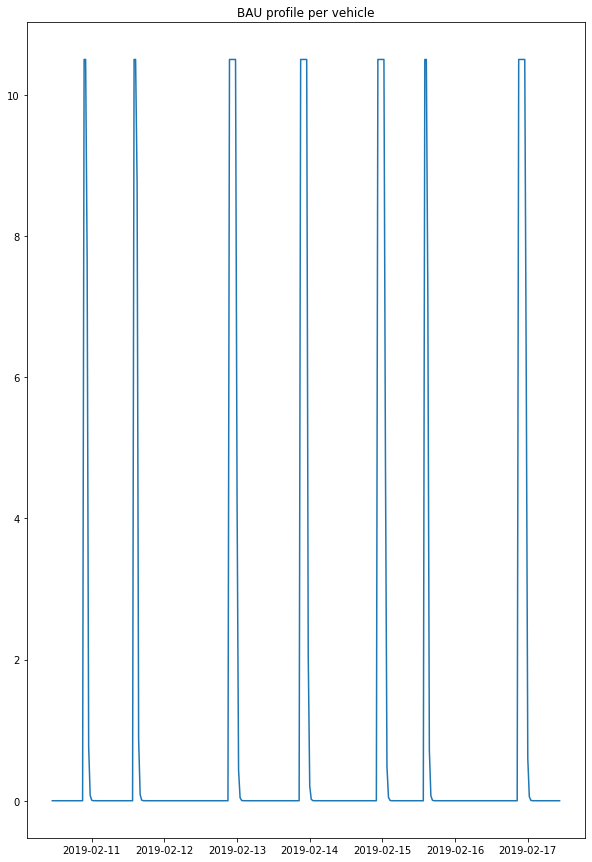

In [52]:
fig, axs = plt.subplots(figsize=(10,15))
axs.plot(x, BAU_profile['Output_BAU'].unstack())
axs.set_title('BAU profile per vehicle')
fig.show()
axs.xaxis.set_major_locator(plt.MaxNLocator(8))
#axs.legend(routes)